In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Validacion modelo
Muchos modelos lo hacen muy bien con los datos que ha usado, pero despues falla con nuevos datos (overfiting); para evitar eso dividimos el set entre entrenamiento y validadcion (training y test).
Hay otros metodos como el cross validation que veremos mas tarde

In [2]:
url2 = "https://raw.githubusercontent.com/joanby/python-ml-course/master/datasets/ads/Advertising.csv"
data_ads = pd.read_csv(url2)
data_ads.head(3)

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3


In [3]:
a = np.random.randn(len(data_ads))

(array([ 1.,  4.,  8., 16., 38., 43., 39., 32., 16.,  3.]),
 array([-3.40165971, -2.81246445, -2.22326919, -1.63407393, -1.04487868,
        -0.45568342,  0.13351184,  0.7227071 ,  1.31190236,  1.90109762,
         2.49029287]),
 <a list of 10 Patch objects>)

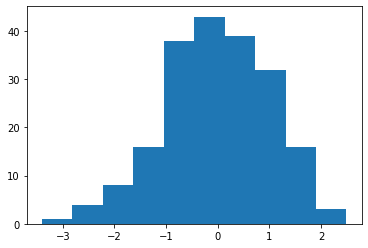

In [4]:
plt.hist(a)

In [5]:
 check = (a<0.8)
 training = data_ads[check]
 test = data_ads[~check] 

In [6]:
print(len(training),len(test))

153 47


In [7]:
import statsmodels.formula.api as smf
lm = smf.ols(formula="Sales~TV+Radio", data=training).fit()

In [8]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     588.6
Date:                Tue, 29 Sep 2020   Prob (F-statistic):           9.72e-72
Time:                        15:10:59   Log-Likelihood:                -302.72
No. Observations:                 153   AIC:                             611.4
Df Residuals:                     150   BIC:                             620.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.0428      0.350      8.686      0.000       2.351       3.735
TV             0.0443      0.002     26.654      0.000       0.041       0.048
Radio          0.1918      0.010     19.682      0.000       0.173       0.211
==============================================================================
Omnibus:                       56.006   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              155.707
Skew:                          -1.474   Prob(JB):                     1.54e-34
Kurtosis:                       6.967   Cond. No.                         427.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

vemos que todos los parametros (R2,pvalue, prob(f-satitics), etc) son muy buenos

### validacion del modelo con el conjunto de testing

In [9]:
sales_pred = lm.predict(test)
# suma cuadrado de las diferencias
SSD = sum((test["Sales"]-sales_pred)**2)
# desviacion estandar de los residuos
RSE = np.sqrt(SSD/(len(test)-2-1))

print(SSD, RSE)

92.1058288007718 1.4468290468906932


In [10]:
sales_mean = np.mean(test["Sales"])
error = RSE/sales_mean
# el porcentaje que no se puede explicar
error

0.10239567113968163

### Datos a tener en cuenta en la regresion
* R^2
* R^2 ajustado
* estadistico f (fisher) un incremento del estadistico, cuando añadimos nueva variable, es positivo
* p_valor (cuando menor sea mejor)
* RSE (la desviacion estandar de los residuos): deberia bajar cuando añadimos mas variables
* error (porcentaje que no se puede explicar): igual que antes ,deberia bajar a medida que añadimos variables

### Regresion linear con sklearn
vamos a ver con sklearn lo mismo que antes ,y como el programa de forma automatica elige las variables adecuadas para la regresion. Solamente tenemos que decirle cuantas variables quieres usar, y el va jugando con ellas para ver cuales son las buenas (recurse feature elminiation y svr)

In [11]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVR

In [12]:
data = data_ads.copy()
feature_cols = ["TV","Radio","Newspaper"]
X = data[feature_cols]
Y = data["Sales"]

In [13]:
# indicamos que queremos un modelo lineal, el numero de variables (2) y en un solo paso (step=1)
estimator = SVR(kernel="linear")
selector = RFE(estimator,2,step=1)
selector = selector.fit(X,Y)


In [14]:
# aqui vemos cuaales se han usado (no se usa newspaper)
selector.support_

array([ True,  True, False])

In [15]:
from sklearn.linear_model import LinearRegression
X_pred = X[["TV","Radio"]]
lm = LinearRegression()
lm.fit(X_pred,Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [16]:
display(lm.intercept_, lm.coef_) # vemos los coeficientes ( ordenada origen y coeficiengte)

2.921099912405138

array([0.04575482, 0.18799423])

In [17]:
# valor de R^2
lm.score(X_pred,Y)

0.8971942610828956

### Variables categoricas   

In [18]:
url4 = "https://raw.githubusercontent.com/joanby/python-ml-course/master/datasets/ecom-expense/Ecom%20Expense.csv"
df = pd.read_csv(url4)
df.head(5)

,Transaction ID,Age,Items,Monthly Income,Transaction Time,Record,Gender,City Tier,Total Spend
0,TXN001,42,10,7313,627.668127,5,Female,Tier 1,4198.385084
1,TXN002,24,8,17747,126.904567,3,Female,Tier 2,4134.976648
2,TXN003,47,11,22845,873.469701,2,Male,Tier 2,5166.614455
3,TXN004,50,11,18552,380.219428,7,Female,Tier 1,7784.447676
4,TXN005,60,2,14439,403.374223,2,Female,Tier 2,3254.160485


In [19]:
# creamos variables dummy para las categoricas
dummy_gender = pd.get_dummies(df["Gender"], prefix="Gender")
dummy_city_tier = pd.get_dummies(df["City Tier"], prefix="City")

In [20]:
dummy_gender.head()

,Gender_Female,Gender_Male
0,1,0
1,1,0
2,0,1
3,1,0
4,1,0


In [21]:
# usamos join para juntarlos (usamos columns names para no afectar al df original ?)
columns_names = df.columns.values.tolist()
columns_names

['Transaction ID',
 'Age ',
 ' Items ',
 'Monthly Income',
 'Transaction Time',
 'Record',
 'Gender',
 'City Tier',
 'Total Spend']

In [22]:
df_new = df[columns_names].join(dummy_gender)
columns_name = df_new.columns.values.tolist()
df_new.head(5)

,Transaction ID,Age,Items,Monthly Income,Transaction Time,Record,Gender,City Tier,Total Spend,Gender_Female,Gender_Male
0,TXN001,42,10,7313,627.668127,5,Female,Tier 1,4198.385084,1,0
1,TXN002,24,8,17747,126.904567,3,Female,Tier 2,4134.976648,1,0
2,TXN003,47,11,22845,873.469701,2,Male,Tier 2,5166.614455,0,1
3,TXN004,50,11,18552,380.219428,7,Female,Tier 1,7784.447676,1,0
4,TXN005,60,2,14439,403.374223,2,Female,Tier 2,3254.160485,1,0


In [23]:
df_new = df_new[columns_name].join(dummy_city_tier)
df_new.head(5)

,Transaction ID,Age,Items,Monthly Income,Transaction Time,Record,Gender,City Tier,Total Spend,Gender_Female,Gender_Male,City_Tier 1,City_Tier 2,City_Tier 3
0,TXN001,42,10,7313,627.668127,5,Female,Tier 1,4198.385084,1,0,1,0,0
1,TXN002,24,8,17747,126.904567,3,Female,Tier 2,4134.976648,1,0,0,1,0
2,TXN003,47,11,22845,873.469701,2,Male,Tier 2,5166.614455,0,1,0,1,0
3,TXN004,50,11,18552,380.219428,7,Female,Tier 1,7784.447676,1,0,1,0,0
4,TXN005,60,2,14439,403.374223,2,Female,Tier 2,3254.160485,1,0,0,1,0


In [24]:
# decidimos que variables queremos usar (ojo tambien podemos usar sklearn, como vimos antes svr y sfe)
feature_cols = ["Monthly Income", "Transaction Time", "Gender_Female", "Gender_Male",
                "City_Tier 1","City_Tier 2","City_Tier 3","Record"]

In [25]:
X = df_new[feature_cols]
Y = df_new["Total Spend"]

In [26]:
lm = LinearRegression()
lm.fit(X,Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [27]:
print(lm.intercept_)
print(lm.coef_)

-79.41713030137362
[ 1.47538980e-01  1.54946125e-01 -1.31025013e+02  1.31025013e+02
  7.67643260e+01  5.51389743e+01 -1.31903300e+02  7.72233446e+02]


In [28]:
# para ver los coeficientes
list(zip(feature_cols,lm.coef_))

[('Monthly Income', 0.14753898049205738),
 ('Transaction Time', 0.1549461254958966),
 ('Gender_Female', -131.02501325554675),
 ('Gender_Male', 131.02501325554695),
 ('City_Tier 1', 76.76432601049535),
 ('City_Tier 2', 55.138974309232445),
 ('City_Tier 3', -131.9033003197278),
 ('Record', 772.2334457445648)]

In [29]:
lm.score(X,Y)

0.9179923586131016

In [30]:
# podemos añadir mas variables y vamos jugando con ellos

### summary de sklearn manual

In [31]:
import sklearn.metrics as metrics
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [32]:
total_spend_pred = lm.predict(X)

In [33]:
regression_results(Y,total_spend_pred)

explained_variance:  0.918
mean_squared_log_error:  0.0562
r2:  0.918
MAE:  682.4664
MSE:  642563.0759
RMSE:  801.6003


In [34]:
# manual, suma de los cuadrados de la diferencia (SSD)
SSD = np.sum((total_spend_pred-Y)**2)
SSD

1517733985.340816

In [35]:
RSE = np.sqrt(SSD/(len(df_new)-len(feature_cols)-1))
RSE

803.1318809818165

In [36]:
sales_mean = np.mean(Y)
sales_mean

6163.176415976714

In [37]:
error = RSE/sales_mean
print("El porcentajes de error que no se puede explicar es :",error*100)

El porcentajes de error que no se puede explicar es : 13.031135680294161


In [38]:
# las prediciones estan 803 (desviacion estandar de los residuos) por encima/debajo de la media 6163 lo cual es mas o menos aceptables

In [39]:
### ahora usamos stadmodel
import statsmodels.api as sm
Xs = sm.add_constant(X)
model = sm.OLS(Y,Xs)
results = model.fit()
results.params

const               -43.318435
Monthly Income        0.147539
Transaction Time      0.154946
Gender_Female      -152.684231
Gender_Male         109.365796
City_Tier 1          62.324848
City_Tier 2          40.699496
City_Tier 3        -146.342779
Record              772.233446
dtype: float64

In [40]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Total Spend   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     4394.
Date:                Tue, 29 Sep 2020   Prob (F-statistic):               0.00
Time:                        15:11:06   Log-Likelihood:                -19145.
No. Observations:                2362   AIC:                         3.830e+04
Df Residuals:                    2355   BIC:                         3.834e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              -43.3184     29.550     -1.466      0.143    -101.266      14.629
Monthly Income       0.1475      0.002     71.753      0.000       0.144       0.152
Transaction Time     0.1549      0.058      2.678      0.007       0.041       0.268
Gender_Female     -152.6842     22.033     -6.930      0.000    -195.891    -109.478
Gender_Male        109.3658     22.316      4.901      0.000      65.606     153.126
City_Tier 1         62.3248     25.108      2.482      0.013      13.089     111.560
City_Tier 2         40.6995     25.263      1.611      0.107      -8.841      90.240
City_Tier 3       -146.3428     25.719     -5.690      0.000    -196.777     -95.909
Record             772.2334      5.359    144.111      0.000     761.725     782.741
==============================================================================
Omnibus:                      342.099   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              197.310
Skew:                           0.573   Prob(JB):                     1.43e-43
Kurtosis:                       2.168   Cond. No.                     1.55e+20
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.13e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [41]:
stat_pred = results.predict(Xs)

In [42]:
SSD1 = np.sum((Y-stat_pred)**2)
SSD1

1517733985.3408165

In [43]:
RSE1 = np.sqrt(SSD1/(len(df_new)-len(feature_cols)-1))
RSE1

803.1318809818166

### Elilminar variables dummy reduntates ( ejemplos si hay tres podemos usar dos porque se da por supuesto la ultima)

* dummy_gender = pd.get_dummies(df["Gender"], prefix="Gender").iloc[:,1:]

* dummy_gender = pd.get_dummies(df["Gender"], prefix="Gender",drop_first=True)

In [ ]:
### transformacion de variables para consequir una relacion no lineal
si no estamos seguros si la relacion es lineal, podemos hacer plot scatter de las variables predictoras; en caso afirmativo debemos transformar esa variable

In [44]:
web = "https://raw.githubusercontent.com/joanby/python-ml-course/master/datasets/auto/auto-mpg.csv"
data_auto = pd.read_csv(web)
data_auto.head(5)

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


In [46]:
data_auto.shape

(406, 9)

In [47]:
# primero eliminamos Nan y despues hacemos plot para ver como se relacionan las variables
data_auto.isnull().sum()

mpg             8
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64

Text(0.5, 1.0, 'CV versus MPG')

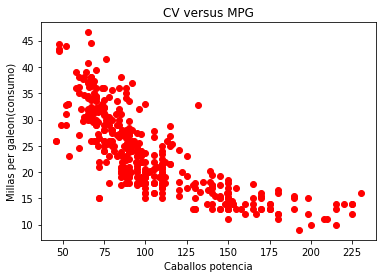

In [50]:
data_auto["mpg"] = data_auto["mpg"].dropna() # esta seria la Y, millas per galeon (consumo gasolina)
data_auto["horsepower"] = data_auto["horsepower"].dropna()
plt.scatter(data_auto["horsepower"],data_auto["mpg"],c="r")
plt.xlabel("Caballos potencia")
plt.ylabel("Millas per galeon(consumo)")
plt.title("CV versus MPG")

### vemos que no tienen una relacion lineal, mas bien exponencial o cuadratatica en forma de parabola. Primero vamos a ver un modelo lineal, ajustando las variables, y despues dependiendo del resultado usaremos una cuadratica o exponencial
* mpg = a + b*horsepower

In [58]:
X = data_auto["horsepower"].fillna(np.mean(data_auto["horsepower"])) # como es una colunmna, para una regresion el sistema espero un dataframe, por eso hay que hacer reshape (1,-1) o usando np.newaxis para que crea una nueva dimension
Y = data_auto["mpg"].fillna(data_auto["mpg"].mean())
X_data = X[:,np.newaxis]

In [59]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_data,Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [60]:
display(type(X), type(X_data))

pandas.core.series.Series

numpy.ndarray

Text(0.5, 1.0, 'representacion de la regresion')

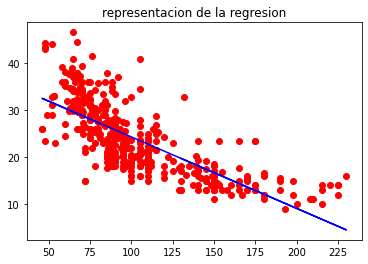

In [61]:
plt.plot(X,Y,"ro")
plt.plot(X,lm.predict(X_data), color="blue")
plt.title("representacion de la regresion")

In [62]:
# vamos a ver como se comporta
lm.score(X_data,Y)

0.574653340645025

In [64]:
# suma cuadrado diferencias
SSD = np.sum((Y-lm.predict(X_data))**2)
# desviacion tipica de los errores
RSE = np.sqrt(SSD/len(X_data)-1)
# media de Y
y_mean = np.mean(Y)
# la parte de las prediciones que no se explican    
error = (RSE/y_mean)*100

print(f"vemos las suma de los cuadrados de la diferencia:{SSD}, la desviacion tipica supone arriba o abajo:{RSE}, lo que supone un porcentaje de:{round(error,2)} ")


vemos las suma de los cuadrados de la diferencia:10315.75196006092, la desviacion tipica supone arriba o abajo:4.940471238582748, lo que supone un porcentaje de:21.01 


In [ ]:
def estadisticos_regresion(X,Y,Y_pred):
    # suma cuadrado diferencias
    SSD = np.sum((Y-Y_pred)**2)
    # desviacion tipica de los errores
    RSE = np.sqrt(SSD/len(X)-1)
    # media de Y
    y_mean = np.mean(Y)
    # la parte de las prediciones que no se explican    
    error = (RSE/y_mean)*100

    print(f"vemos las suma de los cuadrados de la diferencia:{SSD}, la desviacion tipica supone arriba o abajo:{RSE}, lo que supone             un porcentaje de:{round(error,2)} ")

### Modelo de regresion cuadratica
* mpg = a + b*horsepower^2


In [73]:
X_data = X**2
X_data = X_data[:,np.newaxis]


In [74]:
lm = LinearRegression()
lm.fit(X_data,Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [77]:
lm.score(X_data,Y)

0.4849887034823205

In [78]:
# suma cuadrado diferencias
SSD = np.sum((Y-lm.predict(X_data))**2)
# desviacion tipica de los errores
RSE = np.sqrt(SSD/len(X_data)-1)
# media de Y
y_mean = np.mean(Y)
# la parte de las prediciones que no se explican    
error = (RSE/y_mean)*100

print(f"vemos las suma de los cuadrados de la diferencia:{SSD}, la desviacion tipica supone arriba o abajo:{RSE}, lo que supone un porcentaje de:{round(error,2)} ")
print("vemos entonces que con este modelo tampoco mejora mucho")

vemos las suma de los cuadrados de la diferencia:12490.350340501926, la desviacion tipica supone arriba o abajo:5.455676832957554, lo que supone un porcentaje de:23.2 
vemos entonces que con este modelo tampoco mejora mucho


### modelo regresion lineal y cuadratico (tenemos que importar otro paquete); con Polynomial , señalamos los grados, en esta caso es un polinomio de dos grados
* mpg = a + b.horseporwer + c.horseporwer**2

In [79]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

poly = PolynomialFeatures(degree=2)


In [80]:
X_data = poly.fit_transform(X[:,np.newaxis],Y)
lm = linear_model.LinearRegression()
lm.fit(X_data,Y)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [81]:

# suma cuadrado diferencias
SSD = np.sum((Y-lm.predict(X_data))**2)
# desviacion tipica de los errores
RSE = np.sqrt(SSD/len(X_data)-1)
# media de Y
y_mean = np.mean(Y)
# la parte de las prediciones que no se explican    
error = (RSE/y_mean)*100

print(f"R^2:{lm.score(X_data,Y)}")
print(f"vemos las suma de los cuadrados de la diferencia:{SSD}, la desviacion tipica supone arriba o abajo:{RSE}, lo que supone un porcentaje de:{round(error,2)} ")
print("los resultados son un poco mejores en gral ")

R^2:0.6439066584257469
vemos las suma de los cuadrados de la diferencia:8636.180643524502, la desviacion tipica supone arriba o abajo:4.50237502829124, lo que supone un porcentaje de:19.15 
los resultados son un poco mejores en gral 


In [86]:
from sklearn.metrics import mean_squared_error, r2_score
# podemos usar funciones de sklearn
print(f"el error cuadratico medio:{mean_squared_error(Y,lm.predict(X_data))}; la raiz cuadrada seria la varianza, la desviacion tipica de los errores (RSE")
print(f"el estadistico de R^2 :{r2_score(Y,lm.predict(X_data))}")

el error cuadratico medio:21.271380895380545; la raiz cuadrada seria la varianza, la desviacion tipica de los errores (RSE
el estadistico de R^2 :0.6439066584257469


Text(0.5, 1.0, 'representacion de la regresion')

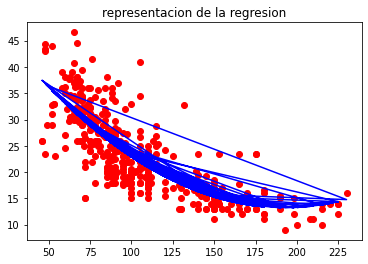

In [88]:
plt.plot(X,Y,"ro")
plt.plot(X,lm.predict(X_data), color="blue")
plt.title("representacion de la regresion")

### El problema de los outliers

Text(0.5, 1.0, 'representacion de outliers')

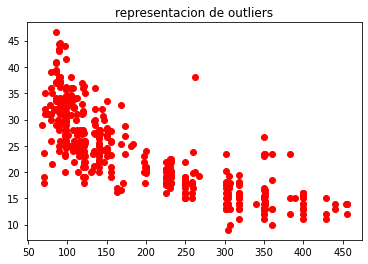

In [89]:
plt.plot(data_auto["displacement"],Y,"ro")
plt.title("representacion de outliers")

In [90]:
# vamos hacer una regresion con y sin outliers para ver si mejoran
X = data_auto["displacement"].fillna(data_auto["displacement"].mean())
X = X[:,np.newaxis]
Y = data_auto["mpg"].fillna(data_auto["mpg"].mean())

lm= LinearRegression()
lm.fit(X,Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [92]:
lm.score(X,Y)

0.6261049762826918

Text(0.5, 1.0, 'representacion de la regresion con outlieres')

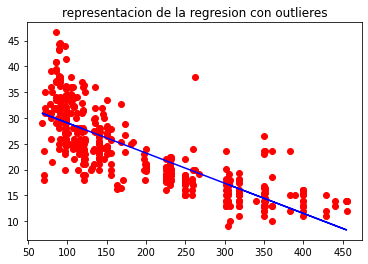

In [93]:
plt.plot(X,Y,"ro")
plt.plot(X,lm.predict(X), color="blue")
plt.title("representacion de la regresion con outlieres")

### Z-score
The Z-score is the signed number of standard deviations by which the value of an observation or data point is above the mean value of what is being observed or measured.
### IQR
The interquartile range (IQR), also called the midspread or middle 50%, or technically H-spread, is a measure of statistical dispersion, being equal to the difference between 75th and 25th percentiles, or between upper and lower quartiles, IQR = Q3 − Q1.

### ojo ver bien esto de abajo que no esta comprobado ¡¡¡

In [104]:
from scipy import stats
z = np.abs(stats.zscore(X))


In [134]:
# usando z score podemos hacer un plot , para ver los outliers y definir un limite (threshold), por ejmplo de 2
X_out = X[(z<1.8).all(axis=1)]


(array([22., 58., 95., 97., 74., 29.,  5., 17.,  3.,  6.]),
 array([0.03073143, 0.27597643, 0.52122144, 0.76646644, 1.01171145,
        1.25695645, 1.50220146, 1.74744646, 1.99269147, 2.23793647,
        2.48318148]),
 <a list of 10 Patch objects>)

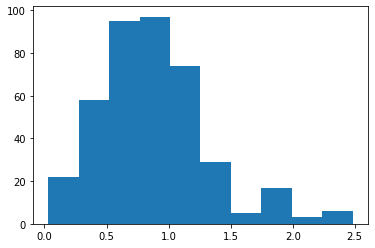

In [135]:
plt.hist(z)

In [136]:
X_out.shape

(383, 1)

In [137]:
Y_out = Y[np.where(z<1.8)[0]]

In [138]:
Y_out.shape

(383,)

In [139]:
lm= LinearRegression()
lm.fit(X_out,Y_out)
lm.score(X_out,Y_out)

0.603664682562178